# Imputación de valores faltantes

Recordemos que no se puede ignorar los valores faltantes debido a que puede generar sesgos si eliminamos los datos. La imputación nos ayuda a estimar los valores ausentes en base a los valores que tenemos en el dataset

## Importar librerías

In [45]:
import sklearn
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
import itertools
import upsetplot

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

c:\Users\shani\anaconda3\Lib\site-packages\upsetplot\plotting.py:15: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


In [46]:
@pd.api.extensions.register_dataframe_accessor("missing")
class DontMissMe:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending=False):

        return self._obj.pipe(
            lambda df: (df[df.isna().sum().sort_values(ascending=ascending).index])
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return (
            self._obj.isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix(suffix)
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
        suffix: str = "_NA",
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing,
                    suffix=suffix,
                ),
            ],
            axis="columns",
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

    def scatter_imputation_plot(
        self, x, y, imputation_suffix="_imp", show_marginal=False, **kwargs
    ):

        x_imputed = f"{ x }{ imputation_suffix }"
        y_imputed = f"{ y }{ imputation_suffix }"

        plot_func = sns.scatterplot if not show_marginal else sns.jointplot

        return (
            self._obj[[x, y, x_imputed, y_imputed]]
            .assign(is_imputed=lambda df: df[x_imputed] | df[y_imputed])
            .pipe(lambda df: (plot_func(data=df, x=x, y=y, hue="is_imputed", **kwargs)))
        )

    def missing_mosaic_plot(
        self,
        target_var: str,
        x_categorical_var: str,
        y_categorical_var: str,
        ax = None
    ):
        return (
            self._obj
            .assign(
                **{target_var: lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])}
            )
            .groupby(
                [x_categorical_var, y_categorical_var, target_var],
                dropna=False,
                as_index=True,
            )
            .size()
            .pipe(
                lambda df: mosaic(
                    data=df,
                    properties=lambda key: {"color": "r" if "NA" in key else "gray"},
                    ax=ax,
                    horizontal=True,
                    axes_label=True,
                    title="",
                    labelizer=lambda key: "",
                )
            )
        )


C:\Users\shani\AppData\Local\Temp\ipykernel_12552\1450815642.py:1: UserWarning: registration of accessor <class '__main__.DontMissMe'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("missing")


In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10,10)
    }
)
sns.set_style("whitegrid")

## El problema de valores faltantes

Como se ha mencionado, los algoritmos de machine learning no tiene en cuenta los valores faltantes, por lo que se eliminan cuando se hace un modelo

In [4]:
airquality_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type='snake'
    )
    .add_column('year', 1973)
    .assign(
        date=lambda df: pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by='date')
    .set_index('date')
)

airquality_df

c:\Users\shani\anaconda3\Lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [8]:
airquality_df.isna().sum()

ozone      37
solar_r     7
wind        0
temp        0
month       0
day         0
year        0
dtype: int64

In [6]:
(
    smf.ols(
        formula = "temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 17 Jan 2024",Prob (F-statistic):,2.93e-18
Time:,10:02:20,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [7]:
(
    smf.ols(
        formula = "temp ~ ozone + solar_r",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 17 Jan 2024",Prob (F-statistic):,1.47e-16
Time:,10:15:20,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


## Limpieza de datos

In [11]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(case_type = "snake")
)
nhanes_raw_df

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


In [36]:
nhanes_df = (
    nhanes_raw_df
    .select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename(
        {
            'age_in_years_at_screening': 'age',
            'current_selfreported_height_inches': 'height',
            'current_selfreported_weight_pounds': 'weight',
            'doctor_told_you_have_diabetes': 'diabetes',
            '60_sec_pulse30_sec_pulse2': 'pulse',
            'total_cholesterol_mgdl': 'total_cholesterol'
        },
        axis=1
    )
    .replace(
        {
            'height': {
                9999: np.nan,
                7777: np.nan,
            },
            'weight': {
                9999: np.nan,
                7777: np.nan,
            },
            'diabetes': {
                'Borderline': np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness() # Ordenar por faltantes
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = 'diabetes',
        function = lambda s: s.astype(int),
        elementwise = False
    )
)
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


## Visualización de datos

<Axes: >

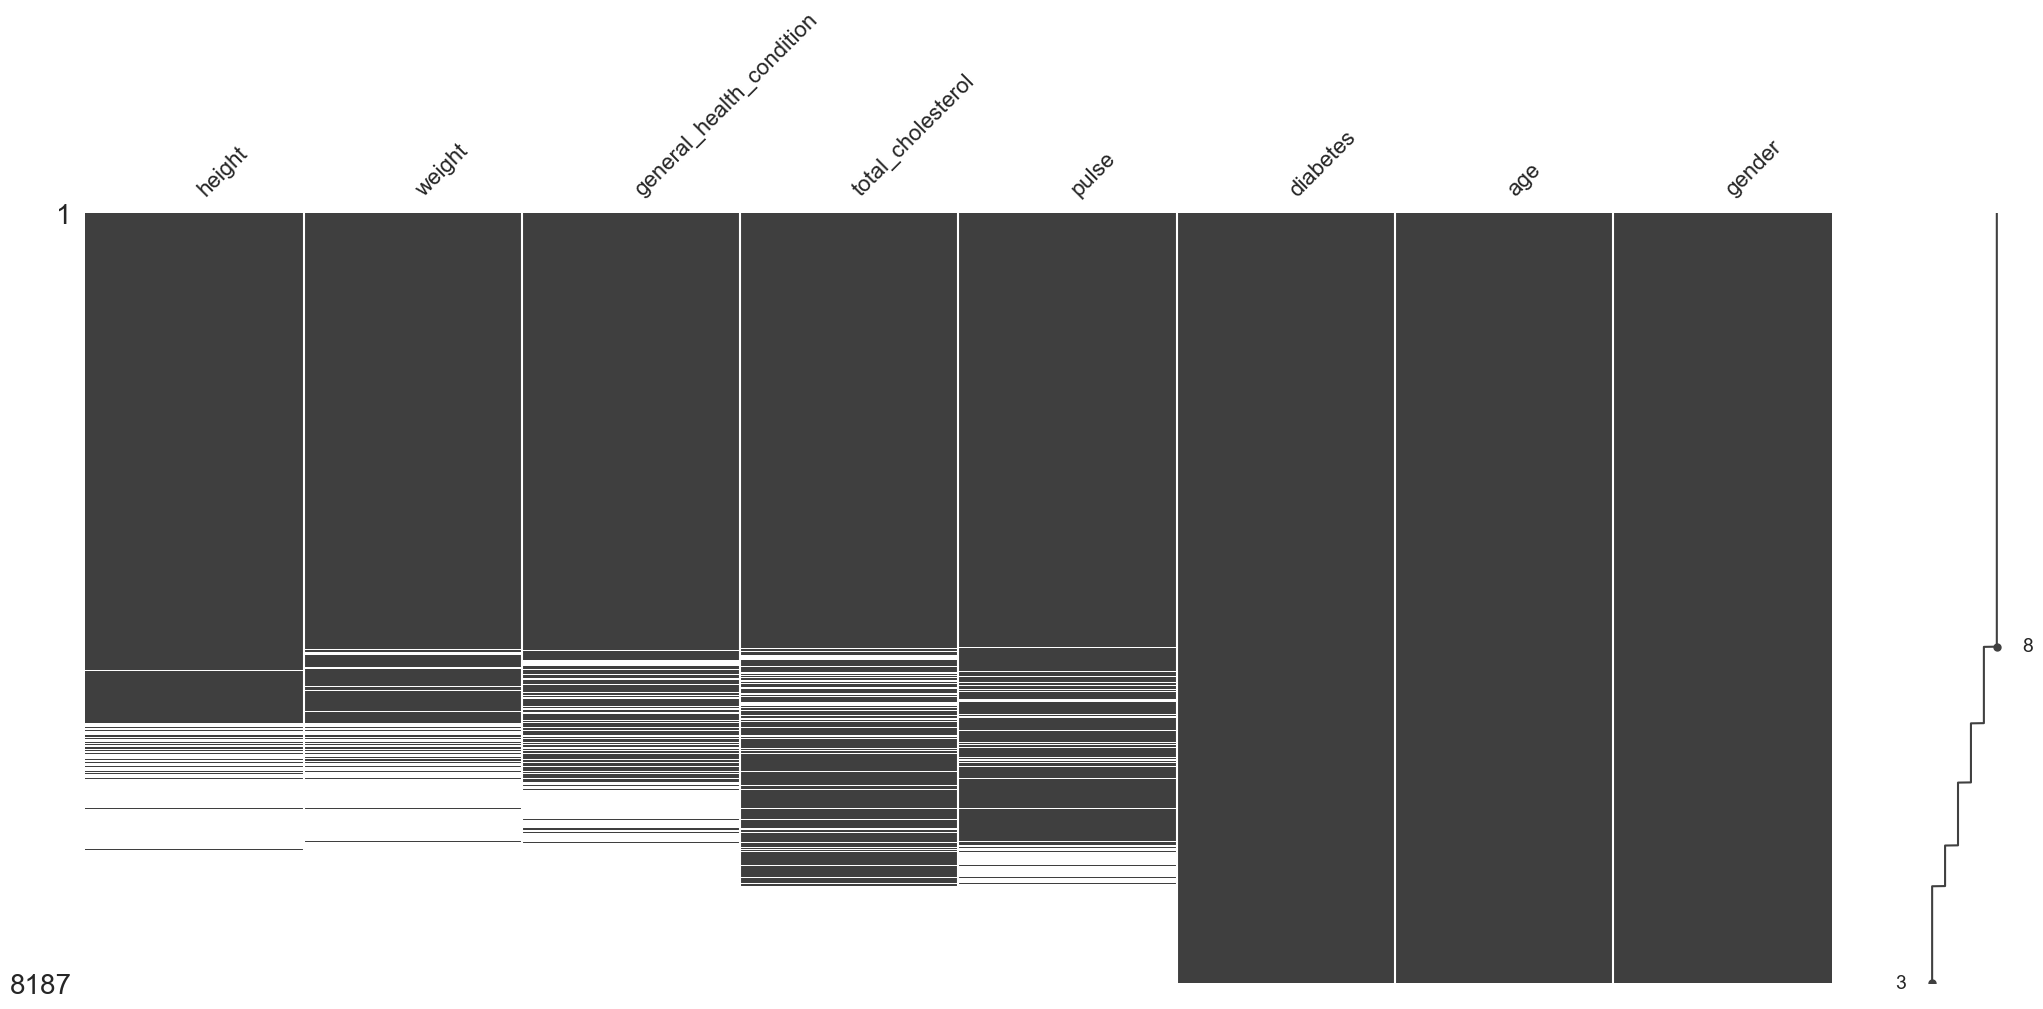

In [43]:
(
    nhanes_df
    .pipe(missingno.matrix, sort="descending")
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

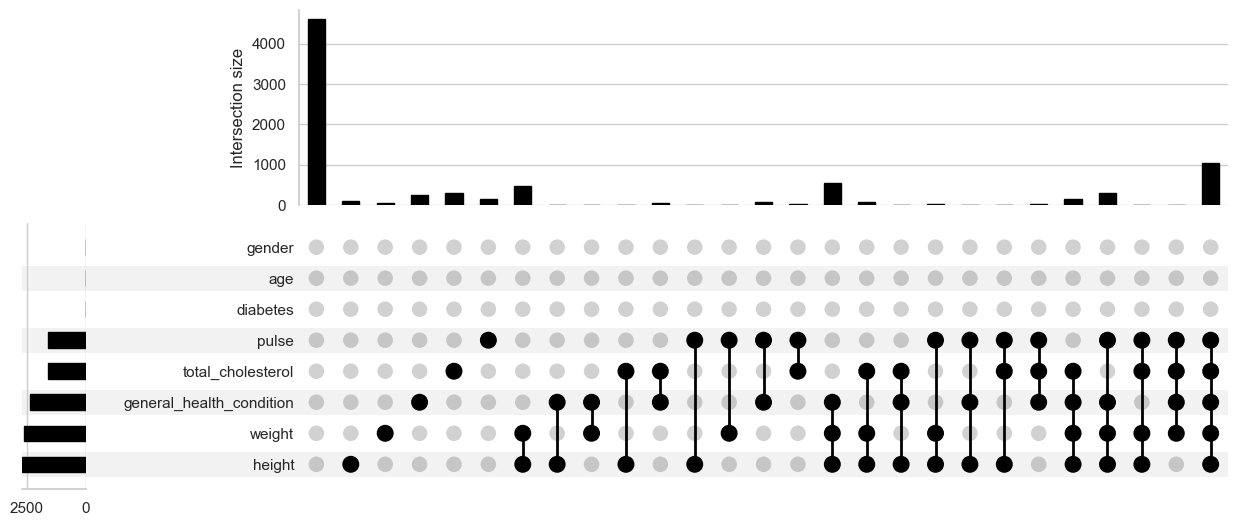

In [47]:
(
    nhanes_df
    .missing.missing_upsetplot()
)

Observamos en la gráfica anterior que hay aproximadamente 1000 valores con 5 columnas faltantes

<Axes: >

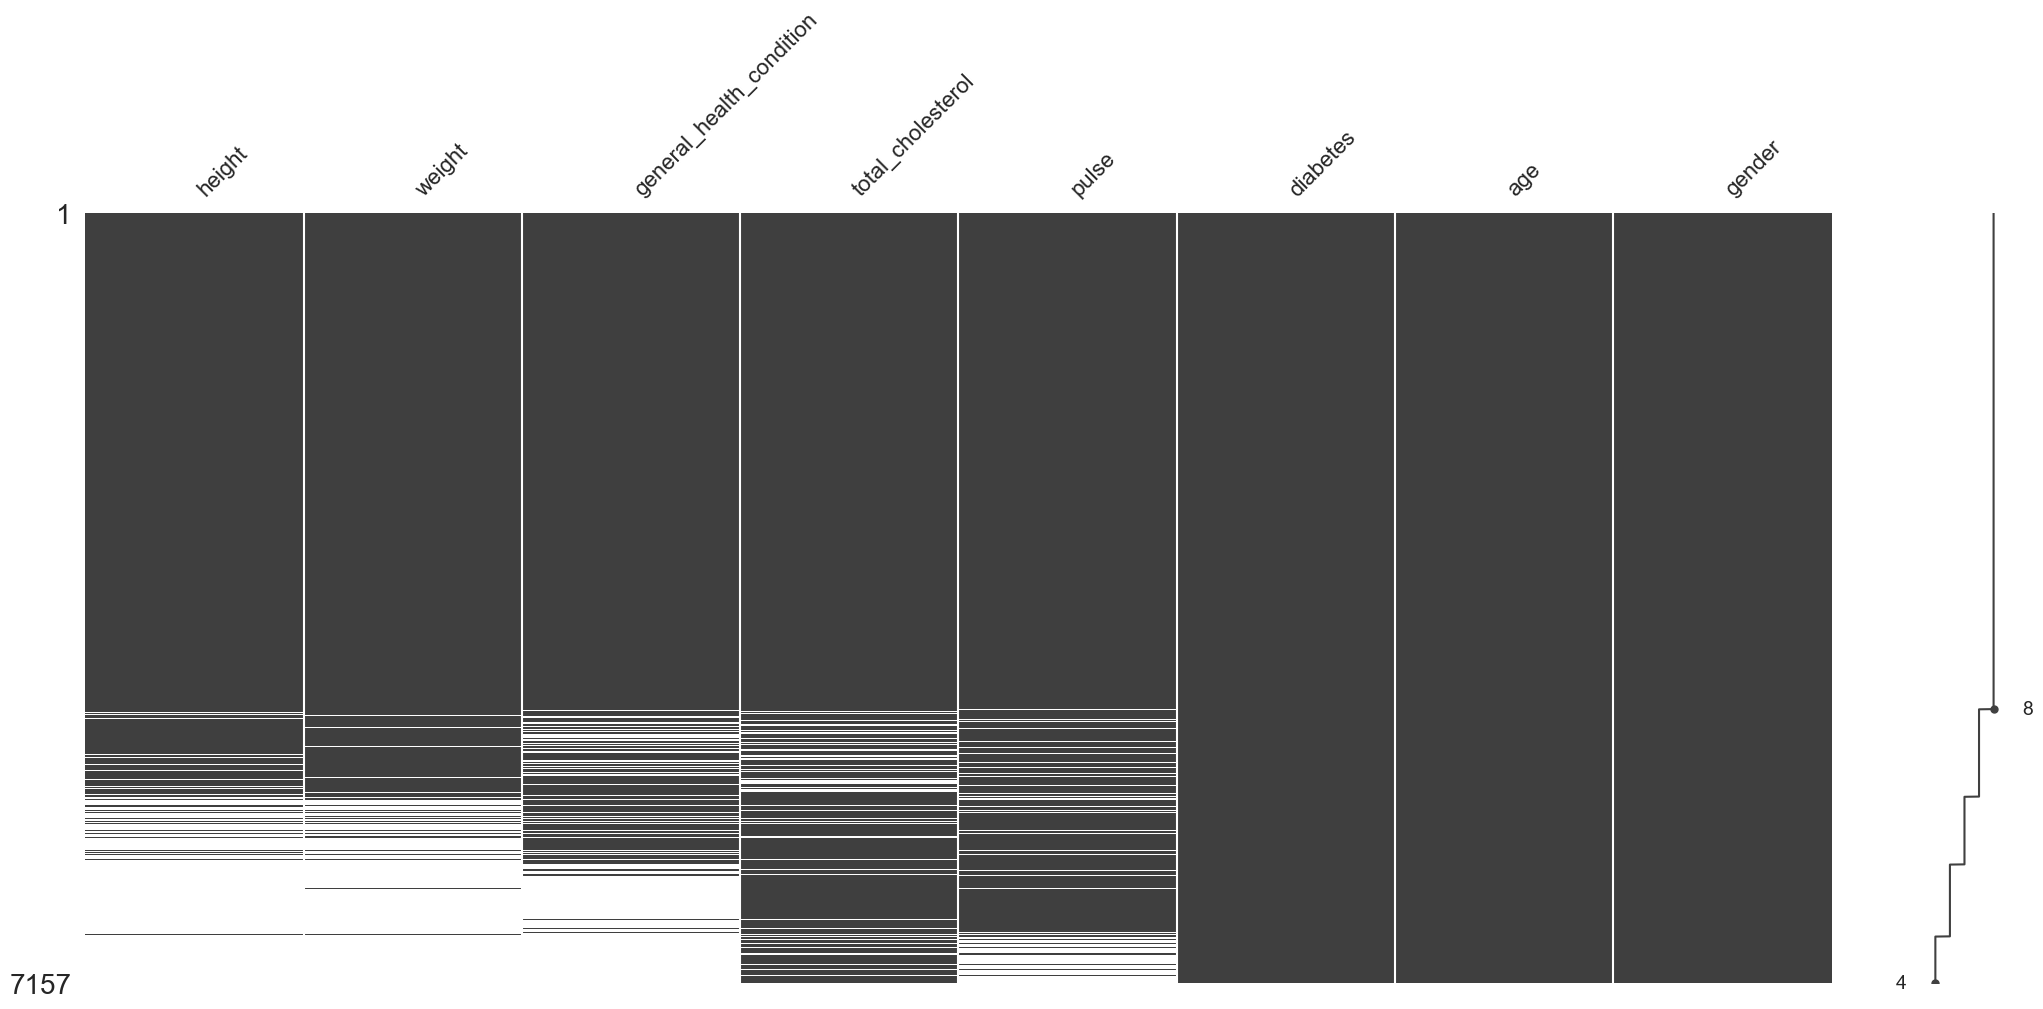

In [51]:
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
)
nhanes_df.pipe(missingno.matrix, sort="descending")

## Mecanismos

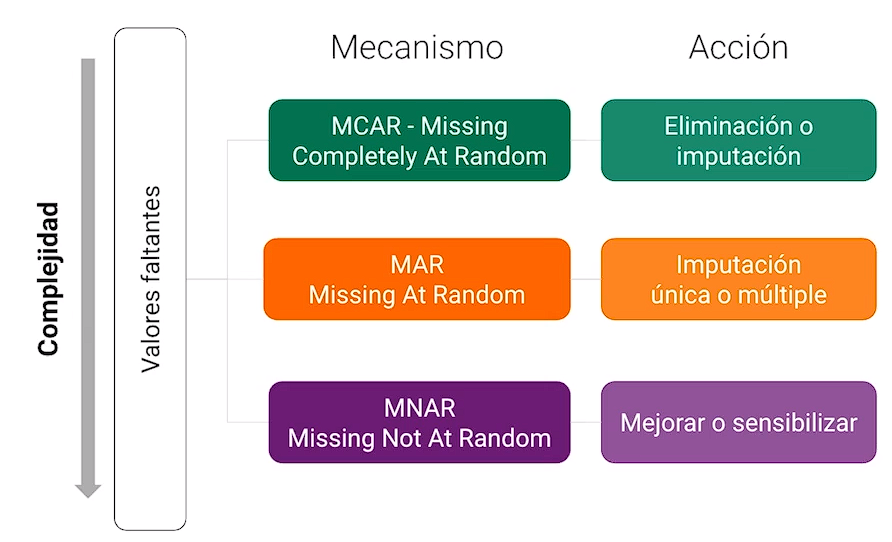